In [113]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [114]:
%cd /gdrive/MyDrive/CSE_519/HW3

/gdrive/MyDrive/CSE_519/HW3


### **Section 1: Library and Data Imports (Q1)**

- Import your libraries and read the data into a dataframe. Print the head of the dataframe. 

In [217]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import permutation_test_score
from sklearn.linear_model import LogisticRegression
from datetime import timedelta
from sklearn.model_selection import train_test_split

%matplotlib inline

Loading the Data into Data Frames

In [218]:
train_df = pd.read_csv('train.csv',parse_dates = ['Date'], low_memory = False)
train_df['StateHoliday'] = train_df['StateHoliday'].replace({0:'0'})

test_df = pd.read_csv("test.csv",parse_dates = ['Date'], low_memory = False)
test_df['StateHoliday'] = test_df['StateHoliday'].replace({0:'0'})

train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [219]:
store_df = pd.read_csv('store.csv')
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Merging 'Store' dataframe with 'Train' and 'Test' Dataframes using inner-join on the column 'Store' present in both.

In [220]:
merged_df = pd.merge(train_df,store_df,how='inner',on='Store')
merged_df_test = pd.merge(test_df,store_df,how='inner',on='Store')

In [222]:
merged_df['week_number'] = merged_df['Date'].dt.week
merged_df['year'] = merged_df['Date'].dt.year
merged_df['month'] = merged_df['Date'].dt.month
merged_df['Day'] = merged_df['Date'].dt.day
merged_df['year_month'] = merged_df['Date'].apply(lambda x: (str(x)[:7]))

In [ ]:
merged_df_test['week_number'] = merged_df_test['Date'].dt.week
merged_df_test['year'] = merged_df_test['Date'].dt.year
merged_df_test['month'] = merged_df_test['Date'].dt.month
merged_df_test['Day'] = merged_df_test['Date'].dt.day
merged_df_test['year_month'] = merged_df_test['Date'].apply(lambda x: (str(x)[:7]))

## Cleaning the Data

### Handling Missing Values

In [121]:
merged_df.isna().sum() / merged_df.shape[0] * 100

Store                         0.000000
DayOfWeek                     0.000000
Date                          0.000000
Sales                         0.000000
Customers                     0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.259730
CompetitionOpenSinceMonth    31.787764
CompetitionOpenSinceYear     31.787764
Promo2                        0.000000
Promo2SinceWeek              49.943620
Promo2SinceYear              49.943620
PromoInterval                49.943620
week_number                   0.000000
year                          0.000000
month                         0.000000
Day                           0.000000
year_month                    0.000000
dtype: float64

Columns Promo2SinceWeek, Promo2SinceYear, PromoInterval, CompetitionOpenSinceMonth and CompetitionOpenSinceYear have more than 30% of the data is missing, so it will be very difficult to work with them if we don't handle them.

We will try to drop the columns relating to Promos i.e., Promo2SinceWeek, Promo2SinceWeek and PromoInterval because almost 50% of these columns are empty and there is no empirical method to handle them. 

In [122]:
merged_df_test.isna().sum() / merged_df.shape[0] * 100

Id                           0.000000
Store                        0.000000
DayOfWeek                    0.000000
Date                         0.000000
Open                         0.001081
Promo                        0.000000
StateHoliday                 0.000000
SchoolHoliday                0.000000
StoreType                    0.000000
Assortment                   0.000000
CompetitionDistance          0.009438
CompetitionOpenSinceMonth    1.495858
CompetitionOpenSinceYear     1.495858
Promo2                       0.000000
Promo2SinceWeek              1.694047
Promo2SinceYear              1.694047
PromoInterval                1.694047
week_number                  0.000000
year                         0.000000
month                        0.000000
Day                          0.000000
year_month                   0.000000
dtype: float64

In [123]:
drop_missing_values_columns = ["Promo2SinceWeek", "Promo2SinceYear", "PromoInterval"]
merged_df = merged_df.drop(drop_missing_values_columns, axis = 1)
merged_df_test = merged_df_test.drop(drop_missing_values_columns, axis = 1)


Filling the Nan values with mode for 'CompetitionDistance' and 'CompetitionOpenSinceYear' columns in both training and testing sets.

I used the forward filling method to clear the Nan values in the 'CompetitionOpenSinceMonth' in both training and testing sets.

I used the mode value to clear the Nan values in 'CompetitionDistance' column of the test data.

In [124]:
merged_df.CompetitionDistance.fillna(merged_df.CompetitionDistance.mode()[0], inplace=True)
merged_df.CompetitionOpenSinceYear.fillna(merged_df.CompetitionOpenSinceYear.mode()[0], inplace=True)
merged_df.CompetitionOpenSinceMonth = merged_df.CompetitionOpenSinceMonth.ffill().bfill()

merged_df_test.CompetitionDistance.fillna(merged_df.CompetitionDistance.mode()[0], inplace=True)
merged_df_test.CompetitionOpenSinceYear.fillna(merged_df.CompetitionOpenSinceYear.mode()[0], inplace=True)
merged_df_test.CompetitionOpenSinceMonth = merged_df.CompetitionOpenSinceMonth.ffill().bfill()
merged_df_test.Open.fillna(merged_df_test.CompetitionDistance.mode()[0], inplace=True)

In [ ]:
merged_df.isna().sum() / merged_df.shape[0] * 100

In [ ]:
merged_df_test.isna().sum() / merged_df.shape[0] * 100

Now that our data is cleaned, we can ask some questions to our data! :D

## **Section 2: Effect of Holidays (Q2)**

**Steps performed**:
1. Obtained all the dates of each holiday type ['a','b','c'] that occur in our dataset.
2. For each holiday type, calculated the total sales are happening on that particular day and 6 days prior to it.
3. I visualized the sales of each holiday type using a bar plot.
4. I also plotted a pie chart comparing the sales during each holiday type.

In [127]:
state_holiday_a_dates = merged_df.loc[merged_df['StateHoliday'] == 'a']['Date']
state_holiday_b_dates = merged_df.loc[merged_df['StateHoliday'] == 'b']['Date']
state_holiday_c_dates = merged_df.loc[merged_df['StateHoliday'] == 'c']['Date']


In [128]:
def get_sales_data_holidays(n,dates):
  sales = [0]*(n+1)
  for date in dates:
    sales[0] += merged_df.loc[merged_df['Date'] == date]['Sales'].sum()
    for i in range(1,n+1):
      temp = date - timedelta(i)
      sales[i] += merged_df.loc[merged_df['Date'] == temp]['Sales'].sum()
  return sales

In [129]:
sales_a = get_sales_data_holidays(6,state_holiday_a_dates)
sales_a

[24336120587,
 126530087044,
 147326298931,
 138627156800,
 78175209127,
 108520236182,
 122349757224]

In [130]:
sales_b = get_sales_data_holidays(6,state_holiday_b_dates)

sales_c = get_sales_data_holidays(6,state_holiday_c_dates)

In [148]:
total_sales = []

for i in range(7):
  total = sales_a[i] + sales_b[i] + sales_c[i]
  total_sales.append(total) 


In [162]:
def plot_bar_plot(sales, title):    
  labels = ['On Holiday','1 Day Before Holiday', '2 Days Before Holiday','3 Days Before Holiday','4 Days Before Holiday', '5 Days before holiday','6 Days before holiday']
  xs = np.arange(len(labels)) 

  plt.bar(xs, sales, align='center')
  plt.title(title)
  plt.ylabel('Sales')

  plt.xticks(xs, labels,rotation=90)
  # plt.yticks(sales)

  plt.show()



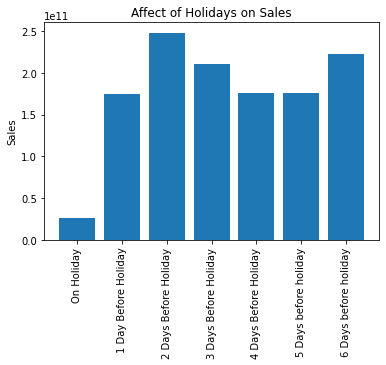

In [163]:
plot_bar_plot(total_sales,'Affect of Holidays on Sales')

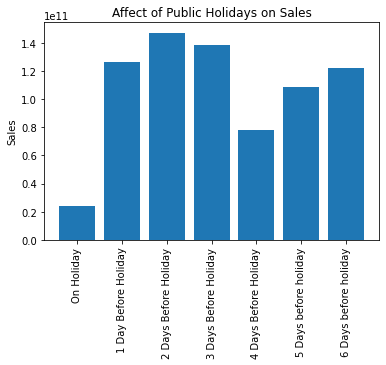

In [164]:
plot_bar_plot(sales_a, 'Affect of Public Holidays on Sales')

**Observation:**

1. The amount of sales on any public holiday is significantly low compared to any other day 1 week prior to the holiday.
2. The sales very high 1-2 days before the holidays.
3. The reason for this can be that people want to get done with their shopping and spend their holiday with their closed ones.
4. The same trend reflects in the Total sales across all the holidays too.

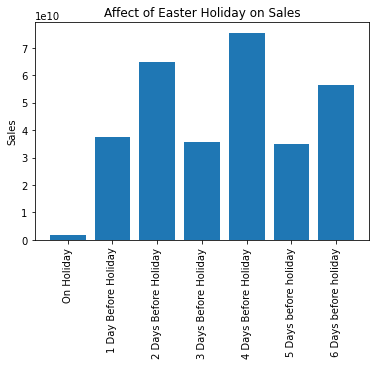

In [165]:
plot_bar_plot(sales_b, 'Affect of Easter Holiday on Sales')

**Observation:**

1. The amount of sales on Easter day is significantly low compared to any other day 1 week before the holiday.
2. This can be attributed to the fact that people want to complete their shopping before the festival and spend the holidays with their families.
3. The sales are high 1 week before the holiday and slowly as we move towards the holiday, the sales go down.

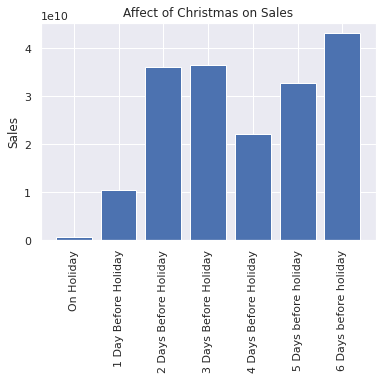

In [216]:
plot_bar_plot(sales_c, 'Affect of Christmas on Sales')

**Observation:**

1. The amount of sales on christmas is significantly low compared to any other day 1 week before the holiday.
2. This can be attributed to the fact that people want to complete their shopping before christmas and spend the holidays with their families.
3. The sales are high 1 week before the holiday and slowly as we move towards the big day, the sales go down.

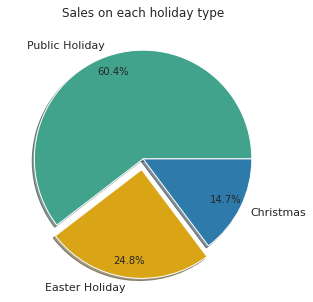

In [215]:
holiday_sales = []

holiday_sales.append(sum(sales_a))
holiday_sales.append(sum(sales_b))
holiday_sales.append(sum(sales_c))


total=total_sales[0]

for i in range(len(holiday_sales)):
  holiday_sales[i]=holiday_sales[i]/total


df = pd.DataFrame({'Sales': holiday_sales}, index=['Public Holiday', 'Easter Holiday', 'Christmas'])

explode = (0, 0.1, 0)

c = ['#41a38c', '#d9a516', '#2e7bab']
plot = df.plot.pie(y='Sales',title="Sales on each holiday type",legend=False,autopct='%1.1f%%',pctdistance=0.85, figsize=(5, 5),shadow=True, startangle=0, explode = explode, colors =c)
plt.ylabel('')
plt.show()

**Observation:**

1. The total number of sales that happened on Public holidays is more than that of both easter and christmas. 
2. This might be because there are more public holidays in an year than easter and christmas holidays.
3. Nevertheless, the sales on christmas holiday is very less compared to the other 2 categories. This might be attributed to the fact that people want to spend time with their families instead of doing shopping, given the cold winter season.

## **Section 3: Most and Least selling stores (Q3a & Q3b)**

### Steps performed:



1. I have taken the columns 'Store', 'Date' and 'Sales' and grouped them using the 'Store' column.
2. I applied min and max as aggregations on 'Date' column to get the start and end-dates of data for each store.
3. I calculated the difference between the start and end date and divided it with an timedelta[1 month] object to get the number of months.
4. Next, I got all the store-id's which have atleast 6 months of data.
5. Next I grouped 'Sales' and 'Stores' columns using the 'Store' column with an sum aggregation.
6. I sorted the list in descending order. Hence, my top 5 rows are top performing stores and bottom 5 rows are low performing stores.
7. To visualize how these groups fared agained each other and also within the group, I plotted line graphs of their sales for each week.



In [170]:
# Getting the stores with atleast 6 months of data
store_sales = merged_df[["Store","Date","Sales"]].groupby(["Store"])
store_sales = store_sales.agg(start_date=('Date', np.min), end_date=('Date', np.max))
store_sales[['start_date','end_date']] = store_sales[['start_date','end_date']].apply(pd.to_datetime, format='%Y-%m-%d')

store_sales['diff'] = (store_sales['end_date'] - store_sales['start_date'])/pd.np.timedelta64(1, 'M')
store_sales['diff'] = pd.np.floor(store_sales['diff']).astype(int)


stores_with_6_months_data = store_sales.loc[store_sales['diff'] >= 6]

Observation:

The above analysis shows that all the stores have a minimum of 6 months of data.



In [171]:
sorted_by_sales = merged_df[["Store","Sales"]].groupby(["Store"]).sum().sort_values("Sales",ascending=False)
sorted_by_sales

,Sales
Store,
262,19516842
817,17057867
562,16927322
1114,16202585
251,14896870
...,...
263,2306075
208,2302052
198,2268273


In [172]:
top_5_stores = sorted_by_sales.head(5)
top_5_stores = list(top_5_stores.index)
print("Top 5 stores in terms of sales are:")
for store in top_5_stores:
  print(store)

Top 5 stores in terms of sales are:
262
817
562
1114
251


Top 5 stores in terms of sales are:
1. 262
2. 817
3. 562
4. 1114
5. 251

In [173]:
bottom_5_stores = sorted_by_sales.tail(5)
bottom_5_stores = list(bottom_5_stores.index)
print("Bottom 5 stores in terms of sales are:")
for store in bottom_5_stores:
  print(store)

Bottom 5 stores in terms of sales are:
263
208
198
543
307


Bottom 5 stores in terms of sales are:
1. 263
2. 208
3. 198
4. 543
5. 307

In [174]:
def plot_trends(stores_list,string):
  stores = merged_df.loc[merged_df["Store"].isin(stores_list)][["Store","week_number","Sales"]]
  stores = stores.loc[stores["Store"].isin(stores_list)][["Store","week_number","Sales"]]
  stores = stores.groupby(["Store","week_number"]).sum()
  stores = stores.reset_index(level=['Store', 'week_number'])
  stores = stores.pivot_table('Sales', ['week_number'], 'Store')
  stores.plot(figsize=(20,4), title=string)
  plt.xlabel('Week Number')
  plt.ylabel('Sales')
  plt.show()


Below is the graph for finding patterns between top 5 stores sales across all Weeks in an year. I have considered sum of all sales across top 5 stores per week. 

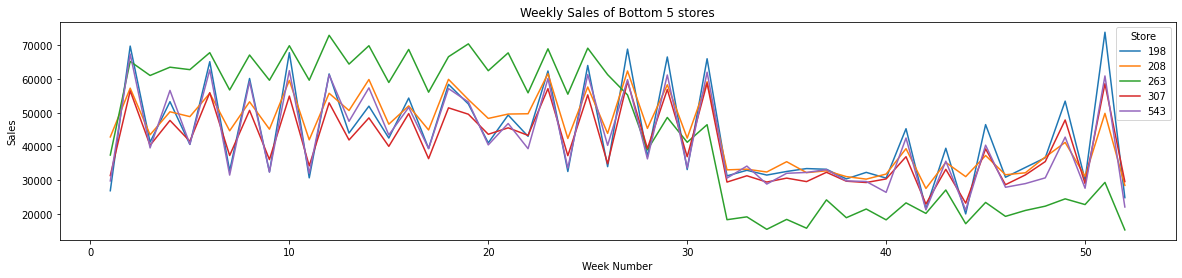

In [175]:
plot_trends(bottom_5_stores,'Weekly Sales of Bottom 5 stores')

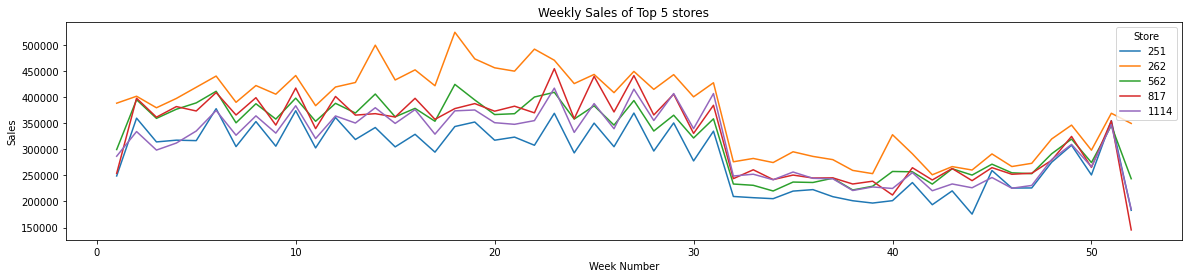

In [176]:
plot_trends(top_5_stores,'Weekly Sales of Top 5 stores')

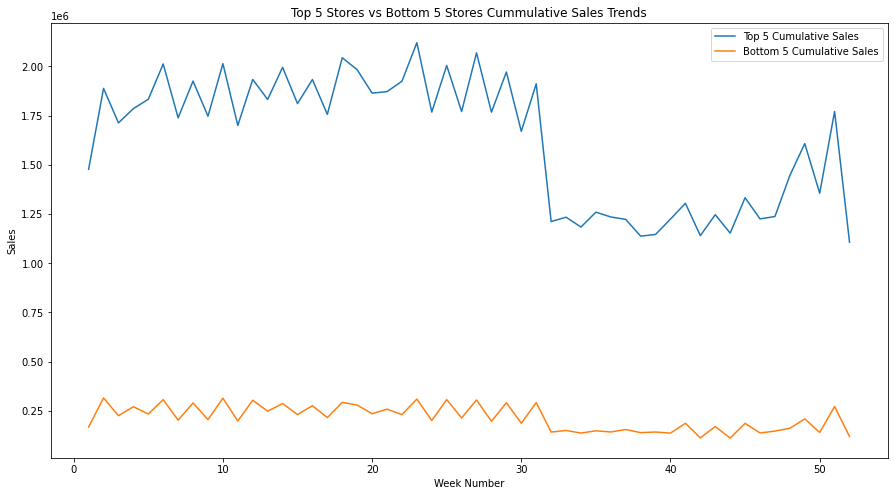

In [184]:
top_5_df = merged_df.loc[merged_df["Store"].isin(top_5_stores)][['week_number','Sales']]
bottom_5_df = merged_df.loc[merged_df["Store"].isin(bottom_5_stores)][['week_number','Sales']]

top_5_df = top_5_df.groupby('week_number').sum()
bottom_5_df = bottom_5_df.groupby('week_number').sum()

axes = top_5_df.plot(figsize=(15,8))
bottom_5_df.plot(ax=axes)
plt.legend(['Top 5 Cumulative Sales','Bottom 5 Cumulative Sales'])
plt.xlabel('Week Number')
plt.ylabel('Sales')
plt.title('Top 5 Stores vs Bottom 5 Stores Cummulative Sales Trends')
plt.show()


**Observations:**

From the above three visualisations, I can conclude the following observations:
1. Sales in the top performing stores almost follows a similar pattern. They peak and fall at the same time.

2. Sales in the bottom performing stores almost follows a similar pattern as top performing stores i.e., They peak and fall at the same time.

3. I observed that, for both top and bottom performing stores, after week 30 the sales tend to decrease slowly. I wonder what might be the reason.
4. The final plot reveals the collective performance of the Top stores vs Bottom stores. Basically, this graph is just a smoothened out version of the above discussed trends.

## **Section 4: Closest Competitor: Distance and Age (Q4a & Q4b)**

**Steps Performed:**
1. Grouped the dataframe using the columns 'Store' and 'Week Number' by using the sum aggregation.
2. Performed a group by operation again on the dataframe using the 'Store' column to get the average sales.
3. Grouped the dataframe using the columns 'Store' and 'CompetitionDistance' by using the mean aggregation.
4. Merged the above two dataframes using the inner join.
5. I created a new column 'competition_category' by dividing it into different quartiles. This is a categorical column which has values 'Very Near', 'Near', 'Far' and 'Very Far'.
6. Then I showed a visualization of sales for each category of competition.
7. Then I showed a visualizzation of how different competition category is affecting the sales of stores.

In [185]:
weekly_sales_df = merged_df[['Sales','Store']]
weekly_sales_df['week_number'] = merged_df['week_number']
weekly_sales_df = weekly_sales_df.groupby(['Store','week_number']).sum().reset_index(level=['Store','week_number'])
weekly_sales_df = weekly_sales_df.groupby('Store').mean().reset_index()[['Store','Sales']]


In [186]:
competition_df = merged_df[['CompetitionDistance','Store']].groupby('Store').mean()
weekly_sales_competetion_df = weekly_sales_df.merge(competition_df, on=['Store'], how = 'inner')

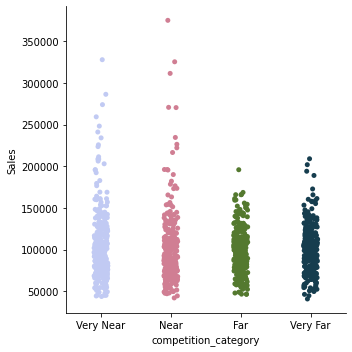

In [198]:
weekly_sales_competetion_df['competition_category'] = pd.qcut(weekly_sales_competetion_df['CompetitionDistance'],q=4,labels=['Very Near', 'Near','Far','Very Far'])
sns.catplot(x='competition_category',y='Sales',data=weekly_sales_competetion_df, palette='cubehelix_r')
plt.show()

**Observations:**

1. There are many stores whose competition is very near to them.
2. The stores with their competition far and very far to them are less compared to the other 2 categories.


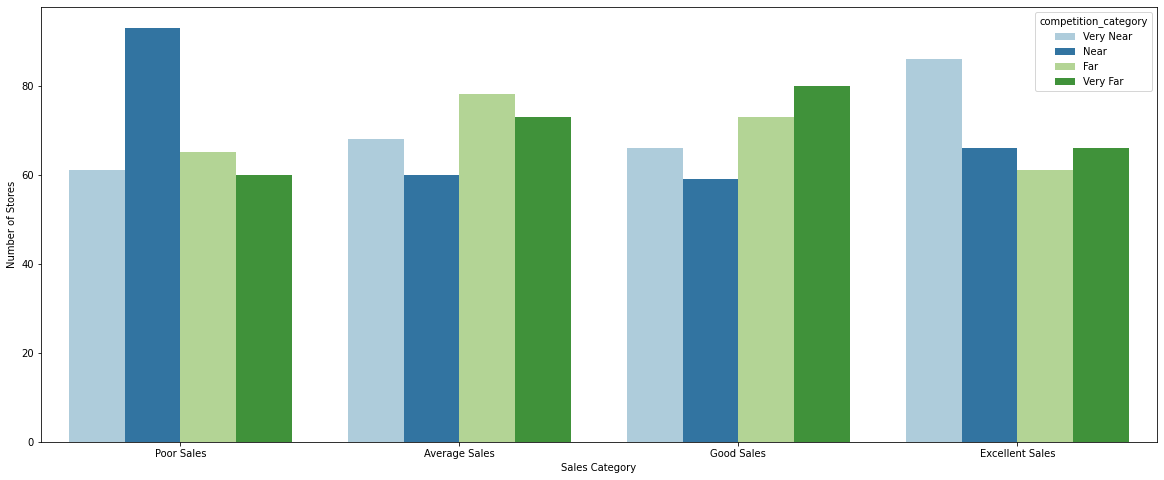

In [194]:
weekly_sales_competetion_df['sales_category'] = pd.qcut(weekly_sales_competetion_df['Sales'],q=4,labels=['Poor Sales', 'Average Sales','Good Sales','Excellent Sales'])
plt.figure(figsize=(20,8))
sns.countplot(hue='competition_category', x='sales_category', data=weekly_sales_competetion_df,orient="h", palette='Paired')
plt.xlabel('Sales Category')
plt.ylabel('Number of Stores')

plt.show()

**Observations:**

1. For stores which performed poorly in terms of sales, majority of them have their competitor either near or very near.
2. For stores which performed averagely in terms of sales, majority of them have their competitor either far or very far.
3. For stores which performed good in terms of sales, most of them have their competitor either far or very far.
4. To my surprise, the stores which had excellent sales actually had competitors very nearby. This might mean that they might have run excellent promotions to up their sales.

## **Section 5: Pearson Correlation of Features (Q5)**

A correlation coefficient measures the extent to which two variables tend to change together. The coefficient describes both the strength and the direction of the relationship.


**Pearson Correlation:**

The Pearson correlation evaluates the linear relationship between two continuous variables. A relationship is linear when a change in one variable is associated with a proportional change in the other variable.



**Steps Performed in this task:**

1. Selected the following columns for calculating the correlations.
     * DayOfWeek
     * Sales
     * Customers
     * Open
     * Promo
2. Calculated the pearson coefficients for the above columns.
3. Plotted a heatmap using the values from the above calculated pearson coefficients.
4. Calculated the spearman coefficients for the above columns.
5. Plotted a heatmap using the values from the above calculated spearman coefficients.


In [199]:
# Pearson Correlation Between 5 interesting Features
correlation_cols = ['DayOfWeek','Sales','Customers','Open','Promo']
pearson_corr_matrix = merged_df[correlation_cols].corr(method='pearson')
pearson_corr_matrix

,DayOfWeek,Sales,Customers,Open,Promo
DayOfWeek,1.000000,-0.462125,-0.386445,-0.528963,-0.392925
Sales,-0.462125,1.000000,0.894711,0.678472,0.452345
Customers,-0.386445,0.894711,1.000000,0.616768,0.316169
Open,-0.528963,0.678472,0.616768,1.000000,0.295042
Promo,-0.392925,0.452345,0.316169,0.295042,1.000000


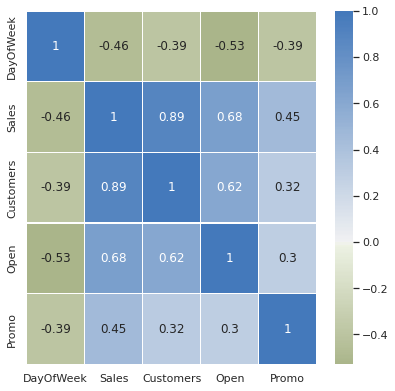

In [200]:
sns.set(rc = {'figure.figsize':(6.5,6.5)})
cmap = sns.diverging_palette(100, 250, as_cmap=True)
sns.heatmap(pearson_corr_matrix,center=0,xticklabels=correlation_cols,yticklabels=correlation_cols,annot=True,linewidths=0.3,cmap=cmap)
plt.show()

In [106]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [107]:
print("Top 5 pairs with Strong Correlation in Pearson:\n\n"+str(get_top_abs_correlations(pearson_corr_matrix, 5)))

Top 5 pairs with Strong Correlation in Pearson:

Sales      Customers    0.894711
           Open         0.678472
Customers  Open         0.616768
DayOfWeek  Open         0.528963
           Sales        0.462125
dtype: float64


**Observation:**
Best Pairs according to Pearson correlation coefficients:

        ```
        Sales      Customers    0.894711
                   Open         0.678472
        Customers  Open         0.616768
        DayOfWeek  Open         0.528963
                   Sales        0.462125 
        ```
1. Sales is highly correlated with Customers and Open. Isn't this very obvious?
2. Customers is highly correlated with the store being Open. Another obvious observation.
3. The day of the week has a very strong negative correlation with sales. This means that mondays are more busier than friday's at the stores. This seems to be an very interesting observation about the data.

**Spearman Correlation:**

The Spearman correlation evaluates the monotonic relationship between two continuous or ordinal variables. In a monotonic relationship, the variables tend to change together, but not necessarily at a constant rate. The Spearman correlation coefficient is based on the ranked values for each variable rather than the raw data.



In [70]:
# Spearman Correlation Between 5 interesting Features
spearman_corr_matrix = merged_df[correlation_cols].corr(method='spearman')
spearman_corr_matrix

,DayOfWeek,Sales,Customers,Open,Promo
DayOfWeek,1.000000,-0.450717,-0.430877,-0.528344,-0.392785
Sales,-0.450717,1.000000,0.903353,0.652013,0.489565
Customers,-0.430877,0.903353,1.000000,0.652015,0.377257
Open,-0.528344,0.652013,0.652015,1.000000,0.295042
Promo,-0.392785,0.489565,0.377257,0.295042,1.000000


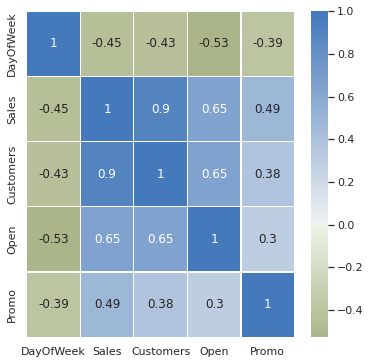

In [108]:
sns.set(rc = {'figure.figsize':(6,6)})
cmap = sns.diverging_palette(100, 250, as_cmap=True)
sns.heatmap(spearman_corr_matrix,center=0,xticklabels=correlation_cols,yticklabels=correlation_cols,annot=True,linewidths=0.3,cmap=cmap)
plt.show()

In [141]:
print("Top 5 pairs with Strong Correlation according to Spearman Correlation:\n\n"+str(get_top_abs_correlations(spearman_corr_matrix, 5)))

Top 5 pairs with Strong Correlation according to Spearman Correlation:

Sales      Customers    0.903353
Customers  Open         0.652015
Sales      Open         0.652013
DayOfWeek  Open         0.528344
Sales      Promo        0.489565
dtype: float64


**Observation:**

Best Pairs according to Spearman correlation coefficients:

        ```
        Sales      Customers    0.903353
        Customers  Open         0.652015
        Sales      Open         0.652013
        DayOfWeek  Open         0.528344
        Sales      Promo        0.489565
        ```
1. Sales is highly correlated with Customers and Open. Similar to that of pearson observation.
2. Customers is highly correlated with the store being Open. Another obvious observation.
3. Similar to that of pearson coefficient, the day of the week has a very strong negative correlation with sales and customers.

**Compared to Pearson coefficient, the Spearman coefficient had only few changes but the order remained the same.**



## **Section 6: Permutation Testing (Q6)**



**Steps Performed:**
1. I have selected the following columns:

```
good_col = "CompetitionOpenSinceMonth"
meaningless_col = "Store"
random_col = "StateHoliday"
```

2. Built a single variable linear regression model using the above features and fitted the model to each column from above.

3. Next I simulated 100 different trials and ranked the model on the metric of root mean squared error.






For Feature: CompetitionOpenSinceMonth
Here is how the distribution of its Permutation scores look like:

Score : 0.005064029586862251


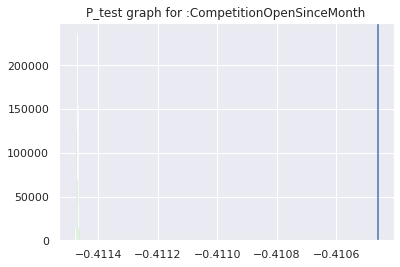

Permutation_score : 0.009900990099009901



For Feature: Store
Here is how the distribution of its Permutation scores look like:

Score : 0.0005240586642838441


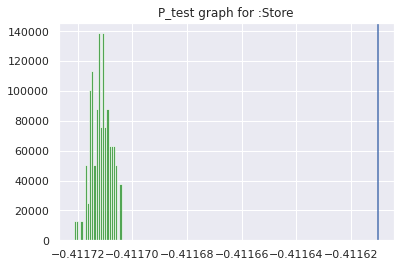

Permutation_score : 0.009900990099009901



For Feature: StateHoliday
Here is how the distribution of its Permutation scores look like:

Score : 0.000362273864200402


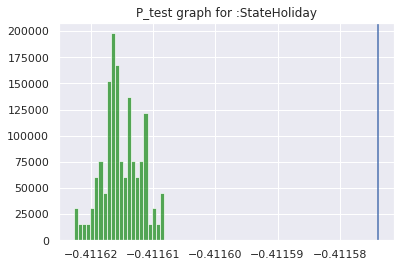

Permutation_score : 0.009900990099009901


In [235]:
good_col = "CompetitionOpenSinceMonth"
meaningless_col = "Store"
random_col = "StateHoliday"

per_test = merged_df[merged_df["Open"] == 1][merged_df["Sales"] != 0].copy()
per_test['StateHoliday'] = per_test['StateHoliday'].map({'0':0,'a':1,'b':2,'c':3})
per_test = per_test.dropna(how='any')
X1,X2,X3,y = np.array(per_test[[good_col]]),np.array(per_test[[meaningless_col]]),np.array(per_test[[random_col]]),np.log(np.array(per_test['Sales']))
features = [X1,X2,X3]

i = 0
for X in features:
  feature = ''
  print('\n\n')
  if i == 0:
    feature = 'CompetitionOpenSinceMonth' 
  elif i == 1:
    feature = "Store"
  else:
    feature = "StateHoliday"
  print("For Feature:", feature)
  print('Here is how the distribution of its Permutation scores look like:\n')
  model = LinearRegression()
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
  model = model.fit(X_train, y_train)
  print("Score :",model.score(X_test,y_test))
  score, perm_score, pvalue = permutation_test_score(model, X_train, y_train, scoring="neg_root_mean_squared_error", n_permutations=100)
  fig,ax = plt.subplots()
  n,bins,patches = ax.hist(perm_score,bins=22,density=1,color='green',alpha=0.65)
  ax.set_title("P_test graph for :"+feature)
  ax.axvline(x=score)
  plt.show()
  print("Permutation_score :",pvalue)
  i += 1


**Observations:**

1. The lower the p_value for a particular feature, the more the importance of the feature.
2. I have observed that the column 'Store' is not as important as the other columns 'StateHoliday' and 'CompetitionOpenSinceMonth'.

## **Section 7: Interesting findings (Q7)**

### Interesting Finding 1

Lets see if the type of store is a significant feature! 

Intuitively, a store's inventory and ambience should be a huge factor.

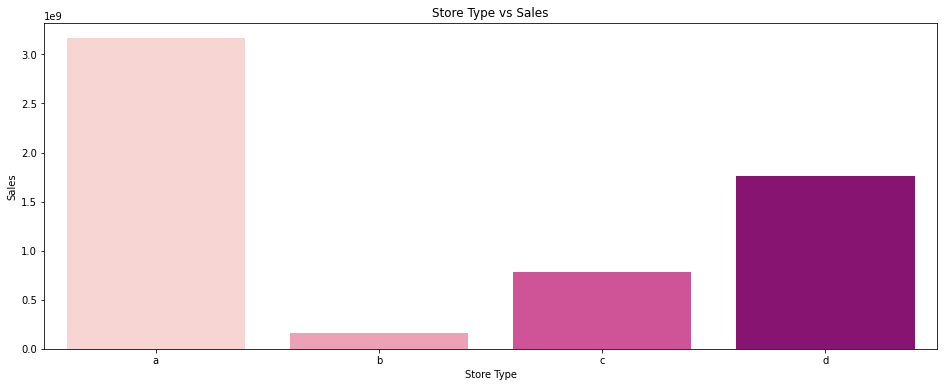

In [82]:
plt.figure(figsize=(16,6))
temp_df = merged_df.groupby(merged_df.StoreType).sum()
sns.barplot(temp_df.index, temp_df.Sales, palette='RdPu')
plt.title("Store Type vs Sales")
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

Store Type 'a' has the most sales than any store type. 

Why did Store type 'a' out-perform all other store types?

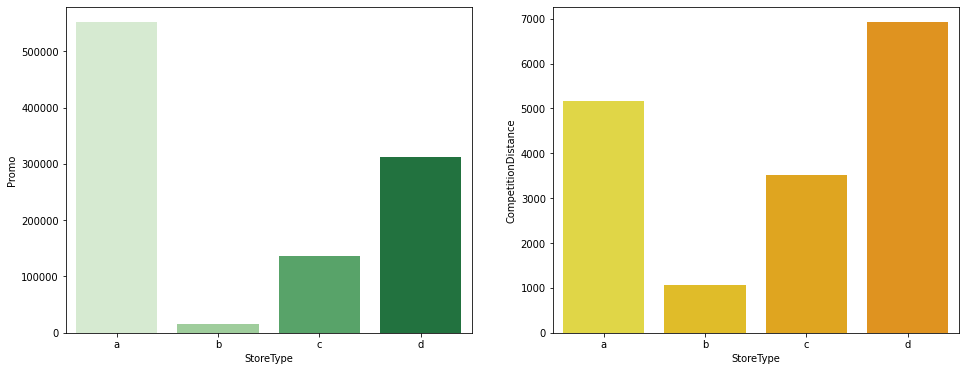

In [30]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

temp_df = merged_df.groupby(merged_df.StoreType).count()
sns.barplot(temp_df.index, temp_df['Promo'], ax=ax1, palette='Greens')

temp_df = merged_df.groupby(merged_df.StoreType).mean()
sns.barplot(temp_df.index, temp_df['CompetitionDistance'], ax=ax2, palette='Wistia')
plt.show()

**Observations:**

1. Store type 'a' has almost 2nd highest competition (distance in meters to the nearest competitor store).
2. Inspite of heavy competition, Store Type 'a' did well because they were able to do the most Promo's. 

Hence, I think it is fair to say promos are a big deal.

### Interesting Finding 2

**What happened to the average sales of a store over time when competition started?**

I have observed that the average sales for store_id = 6 has decreased dramatically since it's competition has opened shop!

Let's see how far this is true with the data.

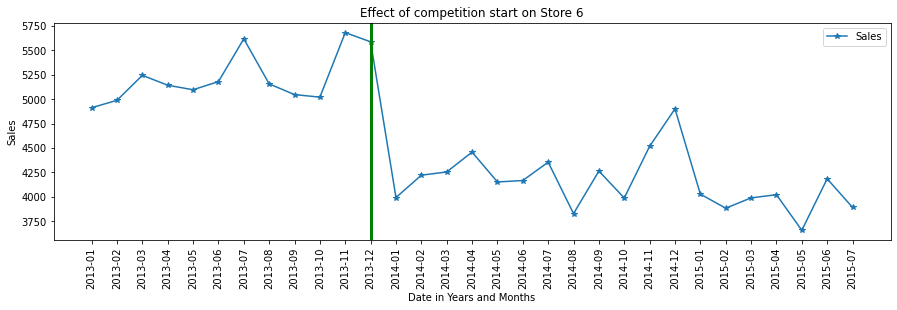

In [80]:
store_id = 6
store_data = merged_df[merged_df["Store"] == store_id]


average_store_sales = store_data.groupby('year_month')["Sales"].mean()

year_competition_started = store_df["CompetitionOpenSinceYear"].loc[store_df["Store"]  == store_id].values[0]
month_competition_started = store_df["CompetitionOpenSinceMonth"].loc[store_df["Store"] == store_id].values[0]

ax = average_store_sales.plot(legend=True,figsize=(15,4),marker='*')
ax.set_xticks(range(len(average_store_sales)))
ax.set_xticklabels(average_store_sales.index.tolist(), rotation=90)


if year_competition_started >= 2013:
    plt.axvline(x=((year_competition_started-2013) * 12) + (month_competition_started - 1), linewidth=3, color='green')

plt.xlabel('Date in Years and Months')
plt.ylabel('Sales')
plt.title('Effect of competition start on Store 6')
plt.show()


From the above graph, I was able to observe

1. Till 2013-12 (December, 2013), store with id=6 was riding high on sales.
2. This was the time, when it's competitor opens.
3. After that point, Store with id=6 has seen drastic decrease in it's sales.
4. It was able to catch pace only after about an year(December, 2014).

### Interesting Finding 3

In this visualization, I would like to observe the affect of different promotions (promo and promo2) on customers and sales. 

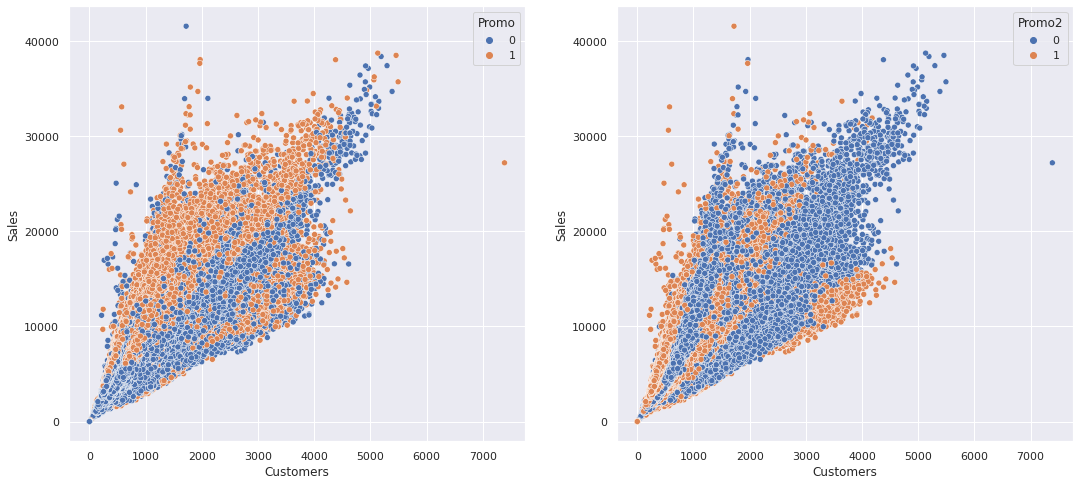

In [393]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
sns.scatterplot(merged_df.Customers, merged_df.Sales, hue=merged_df.Promo, ax=ax1)
sns.scatterplot(merged_df.Customers, merged_df.Sales, hue=merged_df.Promo2, ax=ax2)
plt.show()

**Observations:**
1. There are lot of stores which has run promo type 1 as evident from the number of data points coloured in red in the first graph.
2. Not many stores have run the promo type 2 as evident from the number of data points coloured in blue in the second graph.
3. It Seems like Promo type 1 was more successful for the stores than promo type 2.
4. Stores running promo type 1 gained more sales compared to stores running promo type 2. Maybe that might be the reason for them to discontinue promo 2.



### Interesting Finding 4

**In this visualisation, I would like to point out an observation about the  Performance of Store Type B compared to other store types.**

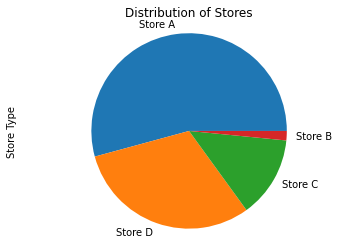

In [109]:
merged_df['StoreType'].value_counts().plot.pie(radius=3,labels=['Store A','Store D','Store C','Store B'])
plt.title('Distribution of Stores')
plt.ylabel('Store Type')
plt.axis('equal')
plt.show()

**Observation 1:**

From the above pie chart, we can observe that the number of stores of type 'b' are very minimal compared to any other store type.

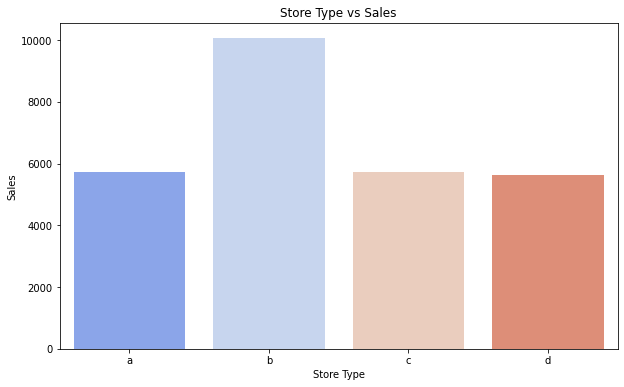

In [111]:
plt.figure(figsize=(10,6))
temp_df = merged_df.groupby(merged_df.StoreType).mean()
sns.barplot(temp_df.index, temp_df.Sales, palette='coolwarm')
plt.title("Store Type vs Sales")
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()


**Observation 2:**

Nevertheless, we can observe from the above bar plot that the **mean amount of sales** of store type 'b' is better than other types.


What could be the reason for this extra-ordinary performance?

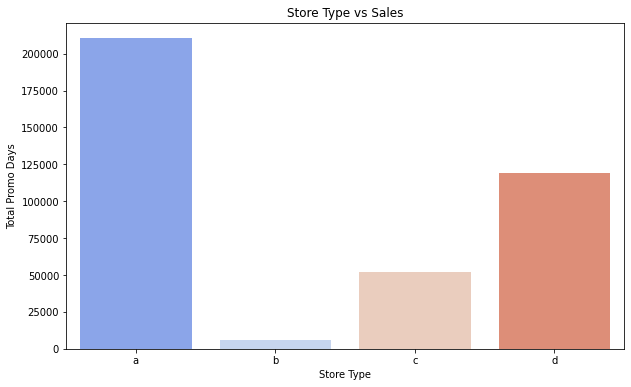

In [112]:
plt.figure(figsize=(10,6))
temp_df = merged_df.groupby(merged_df.StoreType).sum()
sns.barplot(temp_df.index, temp_df.Promo, palette='coolwarm')
plt.title("Store Type vs Sales")
plt.xlabel('Store Type')
plt.ylabel('Total Promo Days')
plt.show()

**Observation 3:**

What's more interesting is, store type 'b' was able to achieve this amazing performance without running much promotion days.

I think this type of store is a people-favourite because of it's ambiance and I would suggest **Rossman** to increase the number of type 'b' stores to gain more profits.

### Interesting Finding 5

**Through this visualisation, I would like to point out an interesting observation about some stores where able to beat their competition by running promotions.**

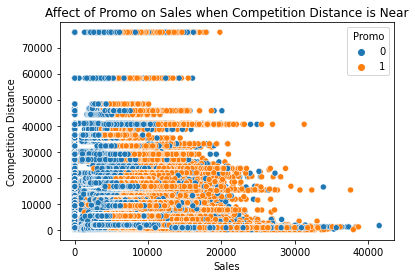

In [47]:
competition_vs_sales_df = merged_df[['Sales','CompetitionDistance','Promo']]
competition_vs_sales_df['CompetitionDistance'] = np.log10(competition_vs_sales_df['CompetitionDistance'])
sns.scatterplot(x="Sales",y="CompetitionDistance",hue="Promo",data=merged_df)
plt.xlabel('Sales')
plt.ylabel('Competition Distance')
plt.title('Affect of Promo on Sales when Competition Distance is Near')
plt.show()

**Observation:**

1. Few stores who have competitors within a distance range of 0-10000, were able to gain more sales by running promotions. As evident from the orange points on the plot.
2. Stores with competitor distance in the same range but who didn't run any promotion, suffered bad sales. As evident from the blue points on the plot.
3. Overall, stores that run promotions are tending to gain better sales than the stores that aren't running one.

## **Section 8: Train Test Split and Modelling (Q8)**

Setting the seed so that we can repeat the experiments again.

In [18]:
np.random.seed(1249585369)

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

Dividing the dataframe into validation and train set.

Validation set consists of data from the months may, june and july of the year 2015.

Train set consists of rest of the data.


In [19]:
validation_set = merged_df[merged_df['year_month'].isin(['2015-05','2015-06','2015-07'])]
train_set = merged_df[~merged_df['year_month'].isin(['2015-05','2015-06','2015-07'])]

Defining our evaluation metric function RMSPE.

In [20]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def RMSPE(y_predict, y):
    w = ToWeight(y_predict)
    rmspe = np.sqrt(np.mean( w * (y_predict - y)**2 ))
    return rmspe

Handling the categorical columns by using Ordinal Encoder

In [21]:
def handling_catogorical(df):
  feature_cat = ['StateHoliday', 'StoreType', 'Assortment']
  df[feature_cat] = enc.fit_transform(df[feature_cat])


handling_catogorical(train_set)
handling_catogorical(validation_set)

Dropping the columns 'Date', 'year_month' and 'Customer' in both validation and train sets

In [24]:
train_set.drop(['Date','year_month','Customers'],inplace=True,axis=1)
validation_set.drop(['Date','year_month','Customers'],inplace=True,axis=1)

Dividing our training and validation sets into X and y's !

In [25]:
X_train, y_train = train_set.loc[:,train_set.columns != 'Sales'],train_set.loc[:,train_set.columns == 'Sales']
X_validation, y_validation = validation_set.loc[:,validation_set.columns != 'Sales'],validation_set.loc[:,validation_set.columns == 'Sales']

print(X_train.shape,y_train.shape)
print(X_validation.shape,y_validation.shape)

(914629, 16) (914629, 1)
(102580, 16) (102580, 1)


### Base Models

I have used Random Forest Regressor (Model-1) and Decision Tree regressor (Model-2) for training my model.


A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

**My hyperparameters for Random Forest Regressor are:**
1. n_estimators: It is the number of trees in the forest. I have taken this value to be 100
2. criterion: The function to measure the quality of a split. I have taken this value to be 'mse', which is the mean sqaured error.
3. max_depth: The maximum depth of the tree. I have taken this value to be 100.

A Decision tree builds regression models in the form of a tree structure. It breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. A Decision trees regression normally uses mean squared error (MSE) to decide to split a node in two or more sub-nodes. 

**My hyperparameters for Decision Tree Regressor are:**
1. max_depth: The maximum depth of the tree. I have taken this value to be 100.
2. random_state: Controls the randomness of the estimator. The features are always randomly permuted at each split, even if splitter is set to "best". I have set this variable as 1.
3. splitter: The strategy used to choose the split at each node. I have taken this value to be 'best'.
4. min_samples_split: The minimum number of samples required to split an internal node. I have taken this value to be 3

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import time


model_1 = RandomForestRegressor(n_estimators=100, 
                             criterion='mse',
                             random_state = 45,
                             max_depth=100)

model_2 = DecisionTreeRegressor(
    max_depth=100,
    random_state=1,
    splitter = "best",
    min_samples_split = 3
    )

start_time = time.time()
fit_1 = model_1.fit(X_train,y_train)
print("Time taken to train model-1 is %s seconds" % (time.time() - start_time))

start_time = time.time()
fit_2 = model_2.fit(X_train,y_train)
print("Time taken to train model-2 is %s seconds" % (time.time() - start_time))

y_preds_1 = fit_1.predict(X_validation)
y_preds_2 = fit_2.predict(X_validation)

Time taken to train model-1 is 512.7059056758881 seconds
Time taken to train model-2 is 7.286883354187012 seconds


In [27]:
y_validation = y_validation.to_numpy()

In [28]:
y_preds_1=y_preds_1.reshape((y_preds_1.shape[0],1))
rsmpe_1 = RMSPE(y_preds_1,y_validation)
y_preds_2=y_preds_2.reshape((y_preds_2.shape[0],1))
rsmpe_2 = RMSPE(y_preds_2,y_validation)

print(rsmpe_1,rsmpe_2)

0.12692775049488908 0.16079811807558878


In [29]:
models = { 'RandomForestRegressor_1':fit_1,
          'DecisionTreeRegressor_1':fit_2
}
model_preds = { 'RandomForestRegressor_1':y_preds_1,
          'DecisionTreeRegressor_1':y_preds_2
}

**Hyperparameter tuning:**

I have tweaked the parameters of the base models.

**Parameters used for Random Forest Regressor:**
1. n_estimators: 100
2. criterion: 'mse'
3. max_depth: 150
4. random_state:45

 

**My hyperparameters for Decision Tree Regressor are:**
1. max_depth: 150
2. random_state: 1
3. splitter: 'best'
4. min_samples_split: 3



In [30]:
model_3 = RandomForestRegressor(n_estimators=100, 
                             criterion='mse',
                             random_state = 45,
                             max_depth=150)

model_4 = DecisionTreeRegressor(
    max_depth=150,
    random_state=1,
    splitter = "best",
    min_samples_split = 3
    )

start_time = time.time()
fit_3 = model_3.fit(X_train,y_train)
print("Time taken to train model-1 is %s seconds" % (time.time() - start_time))

start_time = time.time()
fit_4 = model_4.fit(X_train,y_train)
print("Time taken to train model-2 is %s seconds" % (time.time() - start_time))

y_preds_3 = fit_3.predict(X_validation)
y_preds_4 = fit_3.predict(X_validation)

y_preds_3 = y_preds_3.reshape((y_preds_3.shape[0],1))
rsmpe_3 = RMSPE(y_preds_3,y_validation)
y_preds_4=y_preds_4.reshape((y_preds_4.shape[0],1))
rsmpe_4 = RMSPE(y_preds_4,y_validation)

print(rsmpe_3,rsmpe_4)

models['RandomForestRegressor_2'] = y_preds_3
models['DecisionTreeRegressor_2'] = y_preds_4

Time taken to train model-1 is 515.5970883369446 seconds
Time taken to train model-2 is 7.251969337463379 seconds
0.12692775049488908 0.12692775049488908


In [31]:
model_preds['RandomForestRegressor_2'] = y_preds_3
model_preds['DecisionTreeRegressor_2'] = y_preds_4

models['RandomForestRegressor_2'] = fit_3
models['DecisionTreeRegressor_2'] = fit_4

**Hyperparameter tuning:**

I have changed the parameters of the models like this.

**Parameters used for Random Forest Regressor:**
1. n_estimators: 150
2. criterion: 'mse'
3. max_depth: 200
4. random_state:45

 

**My hyperparameters for Decision Tree Regressor are:**
1. max_depth: 200
2. random_state: 1
3. splitter: 'random'
4. min_samples_split: 5




In [32]:
model_5 = RandomForestRegressor(n_estimators=150, 
                             criterion='mse',
                             random_state = 45,
                             max_depth=200)

model_6 = DecisionTreeRegressor(
    max_depth=200,
    random_state=1,
    splitter = "random",
    min_samples_split = 5
    )

start_time = time.time()
fit_5 = model_5.fit(X_train,y_train)
print("Time taken to train model-5 is %s seconds" % (time.time() - start_time))

start_time = time.time()
fit_6 = model_6.fit(X_train,y_train)
print("Time taken to train model-6 is %s seconds" % (time.time() - start_time))

y_preds_5 = fit_5.predict(X_validation)
y_preds_6 = fit_6.predict(X_validation)

y_preds_5 = y_preds_5.reshape((y_preds_5.shape[0],1))
# print(y_preds_)
rsmpe_5 = RMSPE(y_preds_5,y_validation)
y_preds_6=y_preds_6.reshape((y_preds_6.shape[0],1))
rsmpe_6 = RMSPE(y_preds_6,y_validation)
print(rsmpe_5,rsmpe_6)

model_preds['RandomForestRegressor_3'] = y_preds_5
model_preds['DecisionTreeRegressor_3'] = y_preds_6

models['RandomForestRegressor_3'] = fit_5
models['DecisionTreeRegressor_3'] = fit_6


Time taken to train model-5 is 767.0294382572174 seconds
Time taken to train model-6 is 2.6729705333709717 seconds
0.12652907566105814 0.16004586601467188


---
**Observations:**


1. When I changed the max_depth from 100 to 150 to increase the length of the tree and giving it more degree of freedom in decision making, the time to train has increased marginally but the RMSPE metric remained the same.

2. When I changed the max_depth from 150 to 200 and n_estimators from 100 to 150, the time to train has increased significantly but the improvement on the RMSPE metric was close to negligeble.

Performance Analysis of Random Forest Regressor.

```
Model     Time(in seconds)             RMSPE. 
1         512.70                       0.1269 
2         515.60                       0.1269
3         767.02                       0.1265
```

---
1. When I changed the max_depth from 100 to 150, the time to train has decreased marginally but the RMSPE metric has deteriorated significantly.

2. When I changed the max_depth from 150 to 200, the time to train has decreased drastically but also the RMSPE metric has improved. But it hasn't as much as expected. It is still less than the base Decision tree regressor model.

Performance Analysis of Decision Tree Regressor.

```
Model     Time(in seconds)           RMSPE. 
1         7.28                       0.1269 
2         7.25                       0.1607
3         2.67                       0.1600
```


## **Section 9: t-test (Q9)**

Significance of TTest
Machine learning models are chosen based on their mean performance, often calculated using k-fold cross-validation.

The algorithm with the best mean performance is expected to be better than those algorithms with worse mean performance. But what if the difference in the mean performance is caused by a statistical fluke?

The solution is to use a statistical hypothesis test to evaluate whether the difference in the mean performance between any two algorithms is real or not.


A t-test is a type of inferential statistic used to determine if there is a significant difference between the means of two groups.

In [34]:
from scipy.stats import ttest_ind

values=list(model_preds.values())
names=list(model_preds.keys())

for i in range(len(values)-1):
  for j in range(i+1,len(values)):
    test_score=ttest_ind(values[i],values[j],equal_var=False)[0]
    print("T-Test Score between ",names[i],"and",names[j],"is",test_score)

T-Test Score between  RandomForestRegressor_1 and DecisionTreeRegressor_1 is [-1.96795543]
T-Test Score between  RandomForestRegressor_1 and RandomForestRegressor_2 is [0.]
T-Test Score between  RandomForestRegressor_1 and DecisionTreeRegressor_2 is [0.]
T-Test Score between  RandomForestRegressor_1 and RandomForestRegressor_3 is [-0.0226126]
T-Test Score between  RandomForestRegressor_1 and DecisionTreeRegressor_3 is [-3.12989284]
T-Test Score between  DecisionTreeRegressor_1 and RandomForestRegressor_2 is [1.96795543]
T-Test Score between  DecisionTreeRegressor_1 and DecisionTreeRegressor_2 is [1.96795543]
T-Test Score between  DecisionTreeRegressor_1 and RandomForestRegressor_3 is [1.94570467]
T-Test Score between  DecisionTreeRegressor_1 and DecisionTreeRegressor_3 is [-1.14061811]
T-Test Score between  RandomForestRegressor_2 and DecisionTreeRegressor_2 is [0.]
T-Test Score between  RandomForestRegressor_2 and RandomForestRegressor_3 is [-0.0226126]
T-Test Score between  RandomFor

---
**Observations:**

The above TTest results for each of the predicted values gives us a comparison of performance between any 2 models. Here are my observations:

1. TTest values between Base RandomForestRegressor and RandomForestRegressor_2 and DecisionTreeRegressor_2  are 0. 

  * The closer T is to 0, the more likely there isn't a significant difference. 
  * This means that these three models are  predicting the same.

2. For some models, we can observe that it is marginally off by a whisker. This means that these models are almost predicting the same.
3. Models with negative TTest relation means that they perform exactly in the opposite direction.


## **Section 10: Screenshots (Q10)** 

In [36]:
ids=merged_df_test["Id"]
merged_df_test=merged_df_test.drop(["Id"],axis=1)

In [37]:
handling_catogorical(merged_df_test)

In [38]:
merged_df_test.drop(['Date','year_month'],inplace=True,axis=1)

In [39]:
results = {}
for model in models.keys():
  y_preds = models[model].predict(merged_df_test)
  results[model] = y_preds

for key in results.keys():
  temp = pd.DataFrame()
  temp["Id"]=ids
  temp["Sales"]=results[key]
  temp.to_csv("results/predictions_"+key+".csv",index=False)

**Screenshots and Scores:**

Public Score: 0.12631 

Private Score: 0.13552

Total Number of Kaggle submissions: 12



Kaggle profile link: https://www.kaggle.com/shivasankeerthreddy

Screenshot(s): 
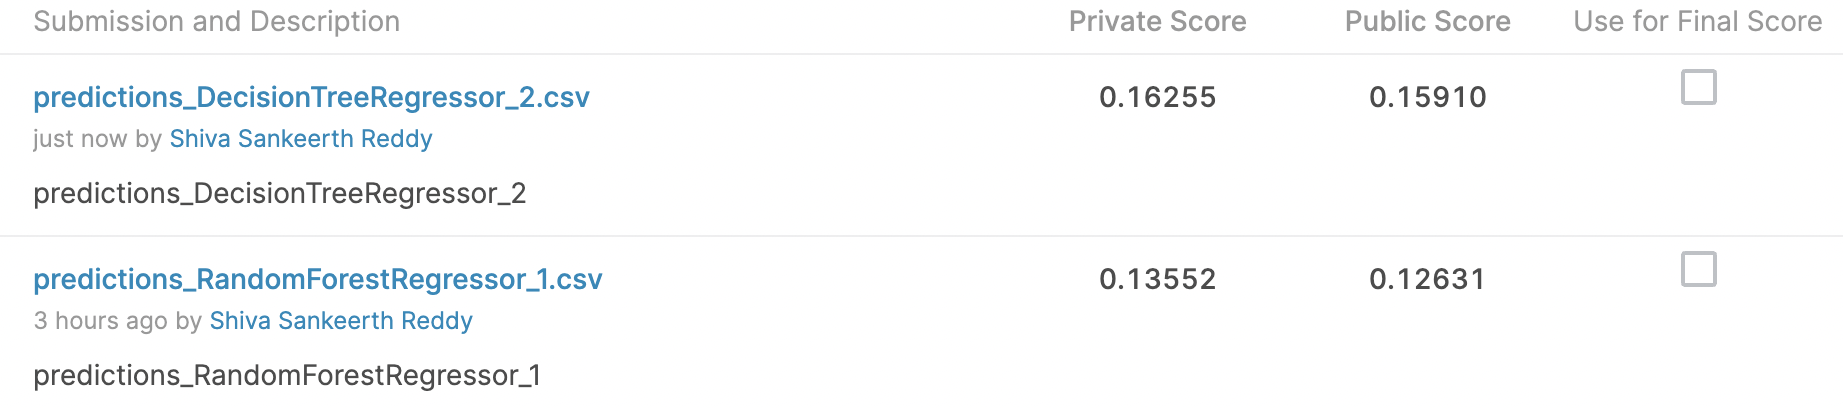


